In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import random
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms, models
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageEnhance, ImageFilter

In [4]:
path = os.path.abspath('/content/drive/MyDrive/Colab Notebooks')
os.chdir(path)
print(path)

/content/drive/MyDrive/Colab Notebooks


### Loading the dataset
We load the train.csv dataset csv. Then perform the following:


*   Preprocess it to remove null records
*   Perform subsampling to get actual training dataset
*   Create python script to restructure images in the correct folder structure for performing classification.
*   Lastly, upload image dataset to google drive and perform classification



In [5]:
train_df = pd.read_csv("aug_train_sample.csv")
train_df.head()

,image_name,benign_malignant,target,images
0,aug/AUG_ISIC_7056748,benign,0,aug/AUG_ISIC_7056748.jpg
1,aug/AUG_ISIC_0927854,benign,0,aug/AUG_ISIC_0927854.jpg
2,aug/AUG_ISIC_0034292,benign,0,aug/AUG_ISIC_0034292.jpg
3,aug/AUG_ISIC_0030688,benign,0,aug/AUG_ISIC_0030688.jpg
4,aug/AUG_ISIC_0031478,benign,0,aug/AUG_ISIC_0031478.jpg


### Preprocessing of the datasets


In [6]:
print("The number of rows and columne in train.csv: {}".format(train_df.shape))
print(train_df.columns)
print("\nDATA TYPES\n")
print(train_df.dtypes)
print("\n=================================================\n")
print("\nCOLUMN COUNT\n")
print(train_df.count())
print("\nNULL COUNT\n")
print(train_df.isnull().sum())
# train_df.dropna(axis=0, inplace=True)

The number of rows and columne in train.csv: (8800, 4)
Index(['image_name', 'benign_malignant', 'target', 'images'], dtype='object')

DATA TYPES

image_name          object
benign_malignant    object
target               int64
images              object
dtype: object



COLUMN COUNT

image_name          8800
benign_malignant    8800
target              8800
images              8800
dtype: int64

NULL COUNT

image_name          0
benign_malignant    0
target              0
images              0
dtype: int64


In [8]:
# Passed a dictionary to astype() function
train_df = train_df.astype({'benign_malignant':'category','target':'category'})

After preprocessing

In [9]:
print("The number of rows and columne in train.csv: {}".format(train_df.shape))

The number of rows and columne in train.csv: (8800, 4)


In [11]:
SEED = 12321
# Seed everything
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

### Helper functions

In [12]:
def plot_histogram(data, plot_properties):
  """ Generic function to plot a histogram.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":""}
  """
  plt.figure(figsize=(10, 6))
  plt.hist(data)
  plt.grid(False)
  plt.title(plot_properties["title"])
  plt.xlabel(plot_properties["xlabel"])
  plt.ylabel(plot_properties["ylabel"])
  plt.show()


def plot_box(data, plot_properties):
  """ Generic function to plot a box plot.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":""}
  """
  plt.figure(figsize=(10, 6))
  plt.boxplot(data)
  plt.grid(False)
  plt.title(plot_properties["title"])
  plt.xlabel(plot_properties["xlabel"])
  plt.ylabel(plot_properties["ylabel"])
  plt.show()
    
def plot_count(data,plot_properties):
    """ Generic for a count plot.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":"", "x":""}
    """
    plt.figure(figsize=(10, 6))
    chart = sns.countplot(data,x=plot_properties['x'],palette='Set2')
    chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=45, horizontalalignment='right')
    plt.title(plot_properties["title"])
    plt.xlabel(plot_properties["xlabel"])
    plt.ylabel(plot_properties["ylabel"])
    plt.show()

def exploring_new_dataset(dataset):
  """ This function performs the role of
      displaying the common information about a dataset
  """
  print("Sample length",len(dataset))
  print(dataset.groupby('benign_malignant').image_name.count())
  plot_count(dataset.benign_malignant, 
               {"title":"IMAGES BY GROUND TRUTH",
                "xlabel":"BENIGN_MALIGNANT","ylabel":"NUMBER OF IMAGES","x":"benign_malignant"})

In [13]:
def get_sample_from_df(sample,n):
    for i in list(range(1,n+1)): 
        if sample.size>=i: 
            return sample.sample(n=i, random_state=seed_value).index[0]
        return [];


def sample_by_patient(dataset,num_sample=1):
  """ Get patient id as category
   Prepare two datasets:
   for each patient_id
       select get records
         if malignant
           sample num_sample
         elif benign
           sample num_sample"""
  unique_patient_id = dataset.patient_id.cat.categories
  malignant_df = dataset[dataset['target'] == 1]

  benign_df = dataset[dataset['target'] == 0]
  sample_indices = []
  #samples per patient
  for  patient_id in unique_patient_id:
      patient_sample = malignant_df[malignant_df['patient_id']==patient_id]
      if patient_sample.size:
          sample_indices.append(get_sample_from_df(patient_sample,num_sample))
      else:
          patient_sample = benign_df[benign_df['patient_id']==patient_id]
          sample_indices.append(get_sample_from_df(patient_sample,num_sample))

  return dataset.loc[sample_indices]

def perform_sampling(dataset,sampling_type="", patient_group_sample=1):
  """function to perform sampling based on
     the sampling type provided.
     Return train, test dataset
  """
  train = None
  test = None
  if sampling_type=="PATIENT_GROUP":
    sample=sample_by_patient(dataset,patient_group_sample)
    train, test = train_test_split(sample, test_size=0.2, shuffle=True, random_state=seed_value)
  else:
    # default train_test split by 8:2
    train, test = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=seed_value)

  return train,test; 

def set_image_file_name(row):
    """We create the image file name"""
    file = row["image_name"]+".jpg"
    return file if os.path.exists(os.path.join(BASE_PATH, file)) else np.nan    


### Prepare the data

A new column images which contains the image file name is added to the data 

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(" Device is {}".format(device))

 Device is cuda:0


In [15]:
BASE_PATH = 'jpeg'
print(BASE_PATH)

jpeg


#### Using Image Augmentation for over sampling malignant class

In [16]:
# load the images using pil

#get the image indices and shuffle them
dataset_size = len(train_df)
indices = train_df.index.tolist()
np.random.shuffle(indices)

# Get a sample to view
batch_size = 32
image_sampler = random.sample(indices,batch_size)

In [17]:
# for i in range(batch_size):
#     sample = train_df.loc[image_sampler[i]]
#     img_name = os.path.join(BASE_PATH,sample['images'])
#     image = Image.open(img_name)
#     print(image.size)

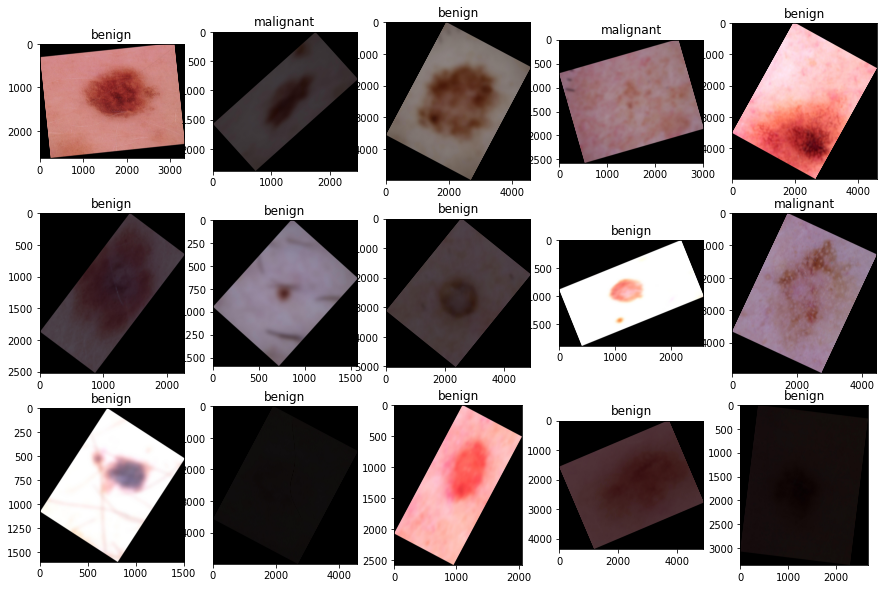

In [20]:
# use the sampled indices to load the images
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    sample = train_df.loc[image_sampler[i]]
    img_name = os.path.join(BASE_PATH,sample['images'])
    image = Image.open(img_name)
    label = sample['benign_malignant']
    ax.imshow(image) # add image
    ax.set(title = f"{label}")